# Baseline Segmentation
*2019-11-15*

*Goal:* The goal of this notebook is to get the structure for a baseline segmentation model.

## Imports and Utils

In [1]:
from itertools import chain
from collections import Counter
from functools import partial
from typing import Callable, List, Dict

from pathlib import Path
Path.ls = property(lambda path: sorted(list(path.iterdir())))

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pelper import pipe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import functional as TF

from wssseg.torch_utils import DEVICE, imagenet_stats
import wssseg.torchseg.transforms as T


%matplotlib inline

# Analysis

## Dataset

In [2]:
from torchvision.datasets import VisionDataset
from typing import Sequence, List

In [3]:
images = Path("../data/raw/top/").ls
masks = Path("../data/raw/masks/").ls


In [4]:
class VaihingenSegmentationDataset(VisionDataset):
    def __init__(self, images: Sequence, masks: Sequence, transforms=None):
        assert len(images) == len(masks)
        assert set([p.name.split("_")[-1] for p in images]) == set([p.name.split("_")[-1] for p in masks])
        
        super().__init__(root=None, transforms=transforms)
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def show_sample(self, idx, size=500, figsize=(20, 6)):
        size = size, size
        img = Image.open(self.images[idx]).resize(size)
        mask = Image.open(self.masks[idx]).resize(size)

        fig, axes = plt.subplots(1, 3, figsize=figsize)
        axes[0].imshow(img)
        axes[1].imshow(mask)
        axes[2].imshow(img)
        axes[2].imshow(mask, alpha=0.3)

        fig.suptitle(f"Sample: {idx}")
        for ax in axes:
            ax.axis("off")

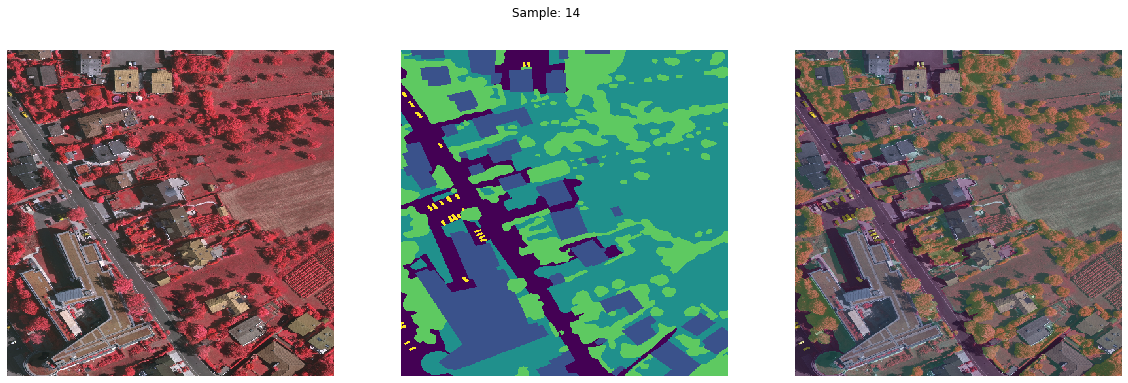

In [5]:
ds = VaihingenSegmentationDataset(images, masks)
ds.show_sample(14)

## Pass through a model

In [6]:
# Taken from https://github.com/pytorch/vision/tree/master/references/segmentation
# and adapted
import wssseg.torchseg.transforms as T


def get_transform(train: bool) -> Callable:
    base_size = 224
    crop_size = 224

    transforms = []
    # min_size = int((0.5 if train else 1.0) * base_size)
    # max_size = int((2.0 if train else 1.0) * base_size)
    # transforms.append(T.RandomResize(min_size, max_size))
    transforms.append(T.RandomCrop(crop_size))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(*imagenet_stats))

    return T.Compose(transforms)

## Overfit on one batch

In [7]:
from torch.optim import Adam
from torchvision.models.segmentation import fcn_resnet101

In [8]:
ds = VaihingenSegmentationDataset(images, masks, get_transform(True))
img, mask = ds[0]
img, mask = img.unsqueeze(0), mask.unsqueeze(0)

model = fcn_resnet101(pretrained=False, num_classes=6)
model = model.to(DEVICE)
optimizer = Adam(model.parameters(), 0.01)

img, mask = img.to(DEVICE), mask.to(DEVICE)

In [9]:
# Sanity check: overfit on one batch/sample
for i in range(50):
    model.train()
    result = model(img)
    loss = nn.functional.cross_entropy(result["out"], mask)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"{i:<3d}: {loss.item():.03f}")

0  : 1.728
1  : 0.970
2  : 2.128
3  : 0.716
4  : 0.707
5  : 0.729
6  : 0.694
7  : 0.502
8  : 0.440
9  : 0.415
10 : 0.383
11 : 0.340
12 : 0.310
13 : 0.293
14 : 0.273
15 : 0.245
16 : 0.217
17 : 0.198
18 : 0.188
19 : 0.170
20 : 0.154
21 : 0.138
22 : 0.127
23 : 0.117
24 : 0.113
25 : 0.106
26 : 0.099
27 : 0.093
28 : 0.090
29 : 0.088
30 : 0.087
31 : 0.082
32 : 0.078
33 : 0.075
34 : 0.075
35 : 0.070
36 : 0.068
37 : 0.067
38 : 0.066
39 : 0.065
40 : 0.062
41 : 0.063
42 : 0.061
43 : 0.058
44 : 0.058
45 : 0.056
46 : 0.056
47 : 0.055
48 : 0.053
49 : 0.052
